In [59]:
!pip install sweetviz 
!pip install catboost
!pip install optuna
import pandas as pd
import numpy as np

     -------------------------------------- 390.6/390.6 kB 1.1 MB/s eta 0:00:00
     -------------------------------------- 224.5/224.5 kB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 78.7/78.7 kB 1.1 MB/s eta 0:00:00


In [60]:
train = pd.read_csv("train_Big Mart.csv")
test = pd.read_csv("test_Big Mart.csv")
ss = pd.read_csv("sample_submission_BM.csv")
train.shape, test.shape, ss.shape

((8523, 12), (5681, 11), (5681, 3))

In [61]:
pd.set_option("display.max_columns", 50)
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Exploratory Data Analysis

In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


# Univariate Analysis

In [63]:
import sweetviz as sv
eda = sv.analyze(train)
eda.show_html('edal.html')

                                             |                                             | [  0%]   00:00 ->…

Report edal.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [64]:
for col in train.iloc[:,0:21].columns:
    print(col,':', train[col].nunique(),':', train[col].isna().sum())

Item_Identifier : 1559 : 0
Item_Weight : 415 : 1463
Item_Fat_Content : 5 : 0
Item_Visibility : 7880 : 0
Item_Type : 16 : 0
Item_MRP : 5938 : 0
Outlet_Identifier : 10 : 0
Outlet_Establishment_Year : 9 : 0
Outlet_Size : 3 : 2410
Outlet_Location_Type : 3 : 0
Outlet_Type : 4 : 0
Item_Outlet_Sales : 3493 : 0


# Target Analysis

In [65]:
import seaborn
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='Item_Type', ylabel='Item_Outlet_Sales'>

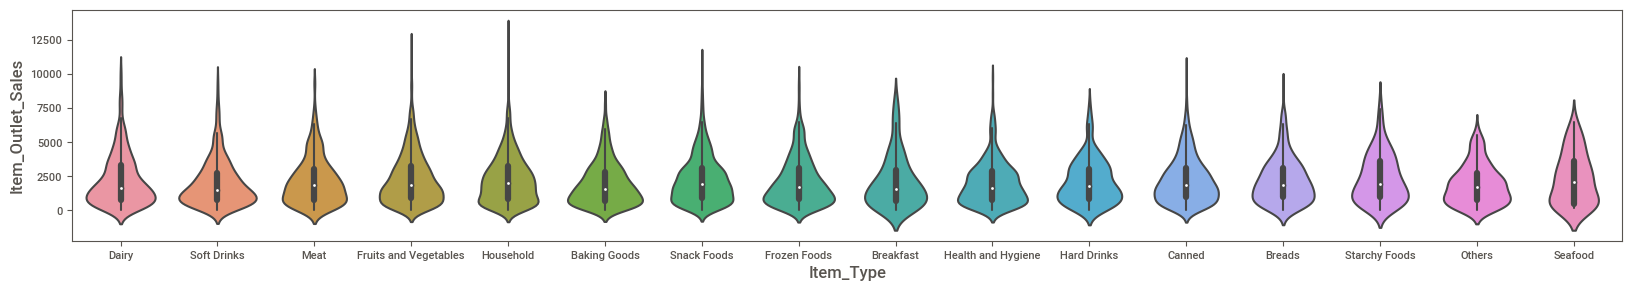

In [66]:
fig, ax = plt.subplots(figsize= (20,3))
seaborn.set(style = 'whitegrid')
seaborn.violinplot(x = "Item_Type", y = "Item_Outlet_Sales", style = "event", data = train)

<AxesSubplot:xlabel='Outlet_Identifier', ylabel='Item_Outlet_Sales'>

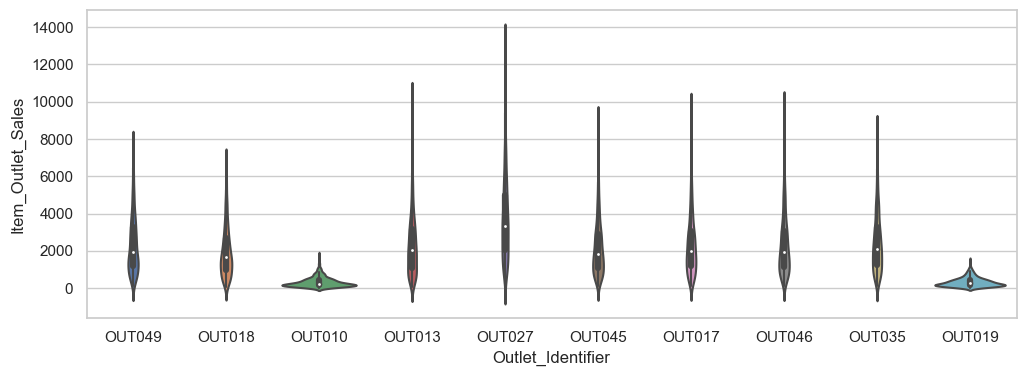

In [67]:
fig, ax = plt.subplots(figsize= (12,4))
seaborn.set(style = 'whitegrid')
seaborn.violinplot(x = "Outlet_Identifier", y = "Item_Outlet_Sales", style = "event", data = train)

<AxesSubplot:xlabel='Outlet_Size', ylabel='Item_Outlet_Sales'>

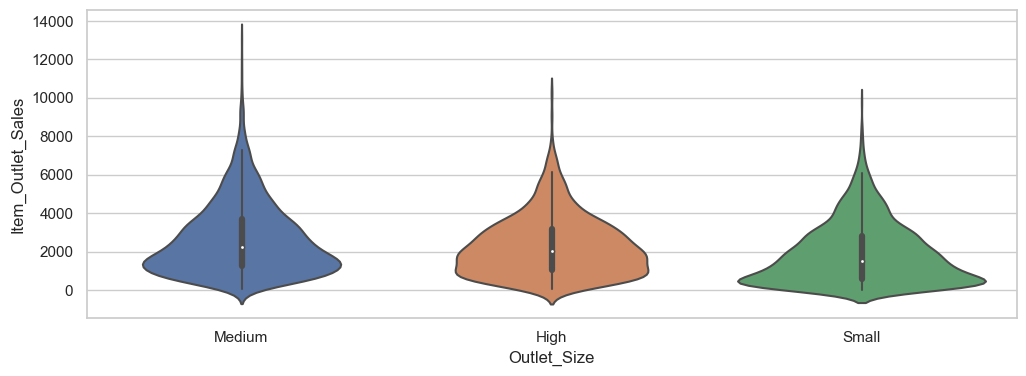

In [68]:
fig, ax = plt.subplots(figsize= (12,4))
seaborn.set(style = 'whitegrid')
seaborn.violinplot(x = "Outlet_Size", y = "Item_Outlet_Sales", style = "event", data = train)

<AxesSubplot:xlabel='Item_MRP', ylabel='Item_Outlet_Sales'>

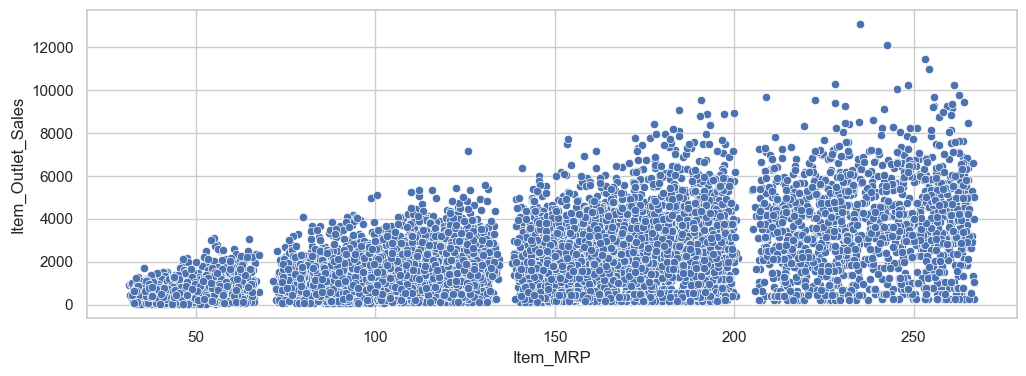

In [69]:
fig, ax = plt.subplots(figsize= (12,4))
seaborn.set(style = 'whitegrid')
seaborn.scatterplot(x = "Item_MRP", y = "Item_Outlet_Sales", data = train)

<AxesSubplot:xlabel='Item_Visibility', ylabel='Item_Outlet_Sales'>

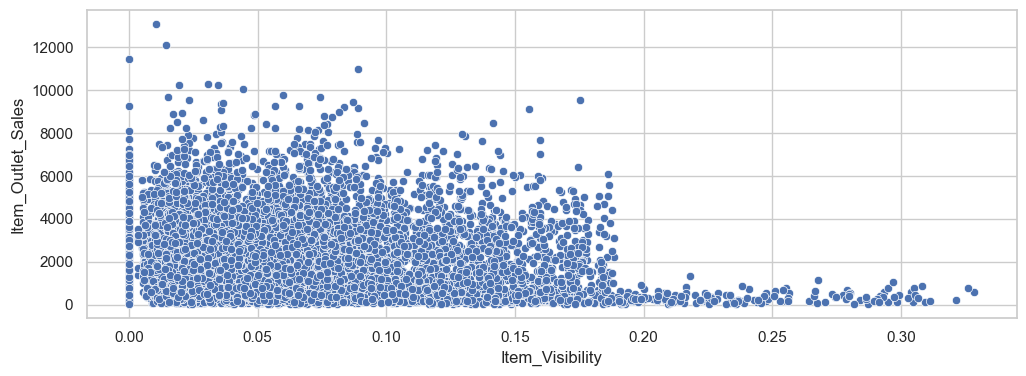

In [70]:
fig, ax = plt.subplots(figsize= (12,4))
seaborn.set(style = 'whitegrid')
seaborn.scatterplot(x = "Item_Visibility", y = "Item_Outlet_Sales", data = train)

<AxesSubplot:xlabel='Item_Weight', ylabel='Item_Outlet_Sales'>

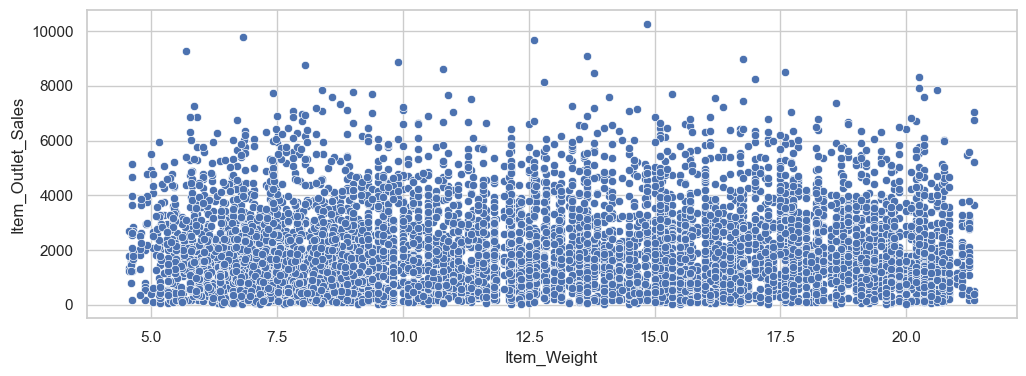

In [71]:
fig, ax = plt.subplots(figsize= (12,4))
seaborn.set(style = 'whitegrid')
seaborn.scatterplot(x = "Item_Weight", y = "Item_Outlet_Sales", data = train)

In [72]:
# Fill in missing values with mean
train["Item_Weight"] = train["Item_Weight"].fillna(train.Item_Weight.mean())
test["Item_Weight"] = test["Item_Weight"].fillna(test.Item_Weight.mean())

# Data Processing and Feature Engineering

In [73]:
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace({'Regular':1,'reg':1,'Low Fat':0, 'low fat':0, 'LF':0})
train['Item_Visibility'] = np.where(train['Item_Visibility'] == 0, "NaN", train['Item_Visibility']).astype(float)
train['Item_Identifier'] = train['Item_Identifier'].str.slice(0,2)
train['running'] = 2013 - train['Outlet_Establishment_Year']
train['price/wt'] = train['Item_MRP'] /train['Item_Weight']
train['Outlet_Size'] = np.where(train['Outlet_Identifier'] == 'OUT010', 'Small', train['Outlet_Size'])
train['Outlet_Size'] = np.where(train['Outlet_Identifier'] == 'OUT017', 'Medium', train['Outlet_Size'])
train['Outlet_Size'] = np.where(train['Outlet_Identifier'] == 'OUT045', 'Medium', train['Outlet_Size'])
train['Item_MRP2'] = np.where(train['Item_MRP'] <69, "A",
                              np.where(train['Item_MRP'] <136, "B",
                                       np.where(train['Item_MRP'] <203, "C", "D")))

                                       
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace({'Regular':1,'reg':1,'Low Fat':0, 'low fat':0, 'LF':0})
test['Item_Visibility'] = np.where(test['Item_Visibility'] == 0, "NaN", test['Item_Visibility']).astype(float)
test['Item_Identifier'] = test['Item_Identifier'].str.slice(0,2)
test['running'] = 2013 - test['Outlet_Establishment_Year']
test['price/wt'] = test['Item_MRP'] /train['Item_Weight']
test['Outlet_Size'] = np.where(test['Outlet_Identifier'] == 'OUT010', 'Small', test['Outlet_Size'])
test['Outlet_Size'] = np.where(test['Outlet_Identifier'] == 'OUT017', 'Medium', test['Outlet_Size'])
test['Outlet_Size'] = np.where(test['Outlet_Identifier'] == 'OUT045', 'Medium', test['Outlet_Size'])
test['Item_MRP2'] = np.where(test['Item_MRP'] <69, "A",
                              np.where(test['Item_MRP'] <136, "B",
                                       np.where(test['Item_MRP'] <203, "C", "D")))                            

<AxesSubplot:>

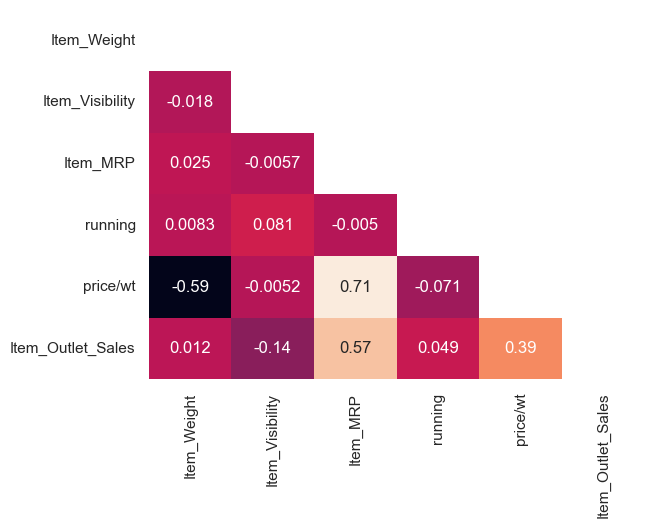

In [74]:
# Check Correlation with target for numeric columns
import seaborn as sns
import numpy as np
corr=train[['Item_Weight','Item_Visibility', 'Item_MRP', 'running', 'price/wt', 'Item_Outlet_Sales']].corr()
mask=np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True,mask=mask,cbar=False)

In [75]:
y_train = train['Item_Outlet_Sales']
x_train = train.drop(['Item_Outlet_Sales', 'Outlet_Establishment_Year'], axis=1)

In [76]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,running,price/wt,Item_MRP2
0,FD,20.750000,0,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1,14,11.598086,B
1,FD,8.300000,1,0.038428,Dairy,87.3198,OUT017,2007,Medium,Tier 2,Supermarket Type1,6,14.749966,B
2,NC,14.600000,0,0.099575,Others,241.7538,OUT010,1998,Small,Tier 3,Grocery Store,15,13.814503,D
3,FD,7.315000,0,0.015388,Snack Foods,155.0340,OUT017,2007,Medium,Tier 2,Supermarket Type1,6,8.074687,C
4,FD,12.695633,1,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3,28,26.229563,D


In [77]:
x_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,running,price/wt,Item_MRP2
0,FD,9.30,0,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,14,26.861204,D
1,DR,5.92,1,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,4,8.153581,A
2,FD,17.50,0,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,14,8.092457,C
3,FD,19.20,1,NaN,Fruits and Vegetables,182.0950,OUT010,Small,Tier 3,Grocery Store,15,9.484115,C
4,NC,8.93,0,NaN,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,26,6.031512,A


In [78]:
x_train = x_train.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x.fillna(x.mode()))

In [79]:
test = test.apply(lambda x: x.fillna(x.mean())  if x.dtype.kind in 'biufc' else x.fillna('NA'))

In [80]:
from catboost import CatBoostRegressor, Pool
categorical_features =  np.where(x_train.dtypes == object )[0]

def objective(trial,data=x_train,target=y_train):
    
    train_x, test_x, train_y, test_y = train_test_split(x_train, y_train, test_size=0.15,random_state=42)
    param = {
        'loss_function': 'RMSE',
        #'task_type': 'GPU',
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
        #'rsm': trial.suggest_uniform('rsm', 0.3, 1.0),
        'subsample': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.006, 0.018),
        'n_estimators':  1000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
    }
    model = CatBoostRegressor(**param,cat_features=categorical_features)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=200,verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [81]:
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-05-30 14:37:37,583] A new study created in memory with name: no-name-67c920dd-bdc8-4470-ace9-f4ea1b2ba4a9
C:\Users\user\AppData\Local\Temp\ipykernel_39056\4178362651.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\user\AppData\Local\Temp\ipykernel_39056\4178362651.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_39056\4178362651.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.

Number of finished trials: 5
Best trial: {'l2_leaf_reg': 4.086190519845578, 'max_bin': 238, 'bagging_fraction': 0.8766643026216603, 'learning_rate': 0.012898791620650614, 'max_depth': 5, 'random_state': 2020, 'min_data_in_leaf': 215}


In [82]:
Best_trial = {'l2_leaf_reg': 0.001061926310,'max_bin': 322,
 'learning_rate': 0.01081467174,'max_depth': 5,'random_state': 2020,'min_data_in_leaf': 163,
              'loss_function': 'RMSE','n_estimators':  1000}

In [83]:
from catboost import CatBoostRegressor, Pool
categorical_features =  np.where(x_train.dtypes == object )[0]

model = CatBoostRegressor(**Best_trial,cat_features=categorical_features)
model.fit(x_train, y_train)
test_pred = model.predict(test[x_train.columns])

0:	learn: 1696.5184236	total: 26.6ms	remaining: 26.6s
1:	learn: 1686.3506974	total: 55.9ms	remaining: 27.9s
2:	learn: 1675.8159590	total: 86.2ms	remaining: 28.7s
3:	learn: 1666.1200752	total: 118ms	remaining: 29.4s
4:	learn: 1656.1390304	total: 151ms	remaining: 30s
5:	learn: 1646.1853280	total: 188ms	remaining: 31.2s
6:	learn: 1636.5468913	total: 225ms	remaining: 31.9s
7:	learn: 1626.8701162	total: 262ms	remaining: 32.4s
8:	learn: 1617.4910508	total: 298ms	remaining: 32.8s
9:	learn: 1608.1377884	total: 329ms	remaining: 32.6s
10:	learn: 1598.9391184	total: 361ms	remaining: 32.5s
11:	learn: 1589.8412201	total: 391ms	remaining: 32.2s
12:	learn: 1580.9399117	total: 422ms	remaining: 32s
13:	learn: 1572.3051193	total: 451ms	remaining: 31.8s
14:	learn: 1563.7949075	total: 482ms	remaining: 31.7s
15:	learn: 1555.3858435	total: 515ms	remaining: 31.7s
16:	learn: 1546.9227814	total: 568ms	remaining: 32.8s
17:	learn: 1538.7294593	total: 597ms	remaining: 32.6s
18:	learn: 1530.6940051	total: 627ms	re

In [84]:
test_pred[test_pred<33]=33
ss['Item_Outlet_Sales'] = test_pred
ss.to_csv('bigmart.csv',index=False)
ss.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1700.066617
1,FDW14,OUT017,1476.283751
2,NCN55,OUT010,632.431894
3,FDQ58,OUT017,2547.506529
4,FDY38,OUT027,6094.700877
